In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
data_frame = pd.read_csv("../datasets/reddit_sentiment.csv")
data_frame.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [4]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [5]:
data_frame = data_frame.dropna()

In [6]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37149 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37149 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 870.7+ KB


In [7]:
X = data_frame["clean_comment"]
y = data_frame["category"]

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from scipy.special import softmax

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

# Load tokenizer and model on GPU
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to("cuda")  # Move model to GPU

predicted_sentiments = []
scores = []

batch_size = 32
max_length = 128  # Adjust as needed

num_batches = len(X) // batch_size + (1 if len(X) % batch_size != 0 else 0)

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if i < num_batches - 1 else len(X)
    batch_comments = X[start_idx:end_idx]

    # Preprocess and tokenize the batch
    batch_comments = [preprocess(comment) for comment in batch_comments]
    inputs = tokenizer(list(batch_comments), return_tensors="pt", padding=True, truncation=True, max_length=max_length).to("cuda")  # Move inputs to GPU

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    # Append batch predictions to the list
    predicted_sentiments.extend(preds.tolist())



In [9]:
y_pred = [x for x in predicted_sentiments]


In [10]:
for i in range(len(y_pred)):
    y_pred[i] = y_pred[i] - 1

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))


              precision    recall  f1-score   support

          -1       0.33      0.86      0.47      8277
           0       0.57      0.44      0.50     13042
           1       0.71      0.25      0.37     15830

    accuracy                           0.45     37149
   macro avg       0.54      0.51      0.45     37149
weighted avg       0.58      0.45      0.44     37149



Lets draw the confusion matrix:


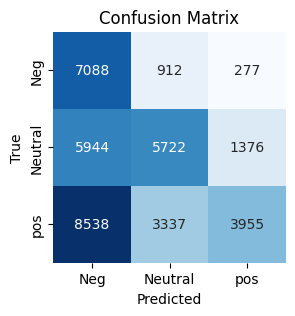

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Create a figure and axis for the plot
    plt.figure(figsize=(len(classes), len(classes)))
    ax = plt.subplot()

    # Create a heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

    # Set labels and title
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_title('Confusion Matrix')

    # Show the plot
    plt.show()


class_names = ['Neg', 'Neutral', 'pos']

plot_confusion_matrix(y, y_pred, class_names)


Clearly this works way better, the scores just go down because of the neutral label how every the classification of Negative Sentiment and Positive Sentiment Comments are really good!